In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mK as mK
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.Get_groups import phase_diagram,make_meanr

from TO_sim.gen_Distribution import Normal
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from tqdm.notebook import tqdm
from scipy.signal import find_peaks
import parmap
from pprint import pprint

In [620]:
seed =10
N = 1000
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)

omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 5
dt = 0.1
t = np.arange(0,5000,dt)
K = 7
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=omega,p_omega=omega)
# plt.plot(np.sort(avg_dtheta[-1]))
# plt.plot((avg_dtheta[-1]))

In [621]:
new_theta = to_ppi(theta)
dtheta_c = np.cumsum(dtheta,axis=0)
sum_time = 200
avg_dtheta = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time

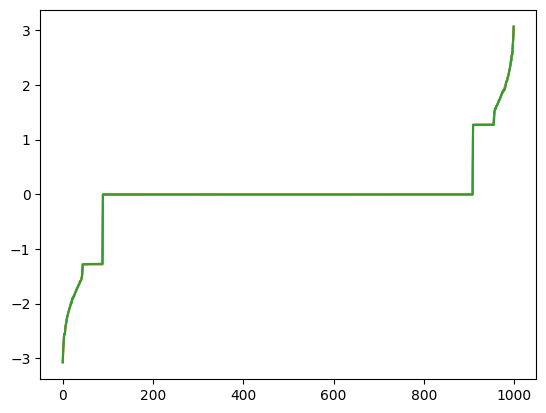

In [622]:
ARG = (theta[-1]-theta[-len(t)//4])//np.pi
ARD = (theta[-1]-theta[-len(t)//4])/(len(t)//4 -1)/dt

# plt.plot(ARG)
plt.plot(ARD)
ARG = (theta[-1]-theta[-len(t)//8])//np.pi
ARD = (theta[-1]-theta[-len(t)//8])/(len(t)//8 -1)/dt
plt.plot(ARD)
plt.plot(avg_dtheta[-1])

In [623]:
import TO_sim.analytical.sec_order_parameter2 as OSP2
import TO_sim.Q_simul as QSIM

In [624]:
Qsimul = QSIM.Q_Norm_simul(N,K=K,m = m,t_end=10000,start_p=True,seed=6)

In [625]:
Qsimul = QSIM.Q_Norm_simul(N,K=K,m = m,t_end=2000,start_p=True,seed=6)
sol = Qsimul.solve()
omega = Qsimul.omega

In [591]:
# N = 2000
# K = 5.7
%timeit sol = Qsimul.solve()

8.18 s ± 341 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [626]:
ARG = (theta[-1]-theta[-5000])//np.pi
ARG =  np.where(ARG<0,ARG,ARG+1)
u,c = np.unique(ARG,return_counts=True)

I_c_o1 =np.where(c>1)
u_o1 = u[I_c_o1]
c_o1 = c[I_c_o1]
u_c = np.argsort(c_o1)[::-1]
UU = u_o1[u_c]


In [627]:
def Get_Group(TH_s,TH_e,L,dt):
    ARG = (TH_s-TH_e)//np.pi
    ARG =  np.where(ARG<0,ARG,ARG)
    u,c = np.unique(ARG,return_counts=True)

    I_c_o1 =np.where(c>5)
    u_o1 = u[I_c_o1]
    c_o1 = c[I_c_o1]
    u_c = np.argsort(c_o1)[::-1]
    UU = u_o1[u_c]

    arr = UU
    main_value = np.min(abs(arr))
    adjusted_arr = arr - main_value
    abs_arr = np.unique(np.abs(adjusted_arr))
    abs_arr
    group_threshold = 5
    G = {}
    GP = {}
    GM = {}
    GN = {}
    G_num = 0
    GP_num = 1
    GM_num = 1
    I_num = 1
    for i in range(1,5):
        GP[i,'I'] = []
        GP[i,'R'] = np.nan
        GP[i,'L'] = np.nan
        GP[i,'V'] = np.nan
        GM[i,'I'] = []
        GM[i,'R'] = np.nan
        GM[i,'L'] = np.nan
        GM[i,'V'] = np.nan
    for i in range(5):
        abs_arr = np.unique(np.abs(adjusted_arr))
        for num in abs_arr:
            abs_adjust_arr = np.abs(adjusted_arr)
            in_group = np.int64(np.round((abs_adjust_arr-num)/group_threshold)) * group_threshold
            is_group = np.where(abs(in_group) < 1)
            not_group = np.where(in_group >= 1)
            if len(is_group) != 0:
                Ra_arr = adjusted_arr[is_group]
                R = Ra_arr + main_value
                if G_num == 0:
                    I, = np.where(np.isin(ARG,R))
                    G[G_num,'I'] = I
                    G[G_num,'R'] = R
                    G[G_num,'L'] = len(I)
                    G[G_num,'V'] = np.mean(R/(L-1)/dt)
                    G_num +=1
                else:
                    gp_idx, = np.where(Ra_arr>0)
                    gm_idx, = np.where(Ra_arr<0)
                    Rp = R[gp_idx]
                    Rm = R[gm_idx]
                    Ip, = np.where(np.isin(ARG,Rp))
                    Im, = np.where(np.isin(ARG,Rm))
                    if (len(Rp) !=0) and (len(Rm) != 0):
                        GM[GM_num,'I'] = Im
                        GM[GM_num,'R'] = Rm
                        GM[GM_num,'V'] = np.mean(Rm/(L-1)/dt)
                        GM[GM_num,'L'] = len(Im)
                        GP[GP_num,'I'] = Ip
                        GP[GP_num,'R'] = Rp
                        GP[GP_num,'V'] = np.mean(Rp/(L-1)/dt)
                        GP[GP_num,'L'] = len(Ip)
                        GP_num += 1
                        GM_num += 1
                    elif (len(Rp) !=0):
                        GP[GP_num,'I'] = Ip
                        GP[GP_num,'R'] = Rp
                        GP[GP_num,'L'] = len(Ip)
                        GP[GP_num,'V'] = np.mean(Rp/(L-1)/dt)

                        GP_num += 1
                    else:
                        GM[GM_num,'I'] = Im
                        GM[GM_num,'R'] = Rm
                        GM[GM_num,'L'] = len(Im)
                        GM[GM_num,'V'] = np.mean(Rm/(L-1)/dt)

                        GM_num += 1

            adjusted_arr = adjusted_arr[not_group]
            break
    return G,GM,GP

In [628]:
TH = 2000
TH_S,TH_E,L = theta[-1],theta[-TH],TH
G,GM,GP = Get_Group(TH_S,TH_E,L,dt =dt)

In [574]:
GM[2,'L']/GM[1,'L'],GP[2,'L']/GP[1,'L']

(nan, nan)

In [575]:
GM[1,'L']/G[0,'L'],GP[1,'L']/G[0,'L']

(0.05609756097560976, 0.05853658536585366)

In [576]:
GM[2,'L']/G[0,'L'],GP[2,'L']/G[0,'L']

(nan, nan)

In [577]:
G[0,'V']

-0.005002501250625312

In [578]:
(GM[1,'V']-G[0,'V'])/G[0,'V'],(GP[1,'V']-G[0,'V'])/G[0,'V']

(81.0, -82.0)

In [579]:
arr = UU
main_value = np.min(abs(arr))
adjusted_arr = arr - main_value
print(main_value)
abs_arr = np.unique(np.abs(adjusted_arr))
abs_arr

1.0


array([  2., 204., 207., 305., 308., 408., 411.])

In [580]:
np.unique(adjusted_arr)

array([-411., -308., -207.,   -2.,  204.,  305.,  408.])

In [581]:
# ARGs = []
# for i in range(len(t)-400):
#     A = (theta[400+i]-theta[i])//np.pi
#     A_m  = A - A[np.argmin(np.abs(A))]
#     ARGs.append(A_m)
# # ARGs = [(theta[5000+i]-theta[i])//np.pi - np.abs(theta[5000+i]-theta[i])//np.pi) for i in range(len(t)-5000)]

In [582]:
GL = np.max(omega[G[0,'I']]) - np.min(omega[G[0,'I']])
GPL = np.max(omega[GP[1,'I']]) - np.min(omega[GP[1,'I']]) 
GML = np.max(omega[GM[1,'I']]) - np.min(omega[GM[1,'I']])

GPL2 = np.max(omega[GP[2,'I']]) - np.min(omega[GP[2,'I']]) 
GML2 = np.max(omega[GM[2,'I']]) - np.min(omega[GM[2,'I']])

ValueError: zero-size array to reduction operation maximum which has no identity

In [583]:
GPL / GL,GML / GL

(0.13905681871428702, 0.1344458415154452)

In [584]:
GPL / GL,GML / GL

(0.13905681871428702, 0.1344458415154452)

In [585]:
GPL2/GL

2.3146517784216885

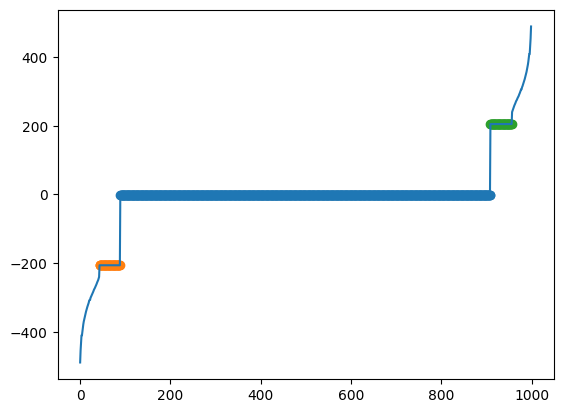

In [586]:
plt.plot(ARG)
plt.scatter(G[0,'I'],ARG[G[0,'I']])
plt.scatter(GM[1,'I'],ARG[GM[1,'I']])
plt.scatter(GP[1,'I'],ARG[GP[1,'I']])
plt.scatter(GM[2,'I'],ARG[GM[2,'I']])
plt.scatter(GP[2,'I'],ARG[GP[2,'I']])


# plt.scatter(GM[3,'I'],ARG[GM[3,'I']])
# plt.scatter(GP[3,'I'],ARG[GP[3,'I']])
# plt.scatter(GM[3,'I'],ARG[GM[3,'I']])
# plt.scatter(GP[3,'I'],ARG[GP[3,'I']])

In [556]:
omega[[]]

array([], dtype=float64)

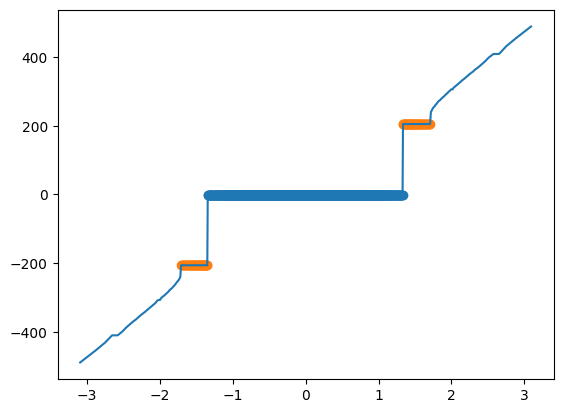

In [571]:
plt.plot(omega,ARG)
plt.scatter(omega[G[0,'I']],ARG[G[0,'I']])
plt.scatter(omega[GM[1,'I']],ARG[GM[1,'I']],color='tab:orange')
plt.scatter(omega[GP[1,'I']],ARG[GP[1,'I']],color='tab:orange')
plt.scatter(omega[GM[2,'I']],ARG[GM[2,'I']],color= 'tab:green')
plt.scatter(omega[GP[2,'I']],ARG[GP[2,'I']],color= 'tab:green')
# plt.scatter(omega[GM[3,'I']],ARG[GM[3,'I']],color= 'tab:red')
# plt.scatter(omega[GP[3,'I']],ARG[GP[3,'I']],color= 'tab:red')


# plt.scatter(omega[GM[4,'I']],ARG[GM[4,'I']])
# plt.scatter(omega[GP[4,'I']],ARG[GP[4,'I']])

In [307]:
def get_TM(x,step):
    x_c = np.cumsum(x,axis=0)
    if x.ndim == 2:
        x_m = (x_c[step:,:] - x_c[:-step,:])/step
    else:
        x_m = (x_c[step:] - x_c[:-step])/step
    return x_m

In [394]:
STEP =  100
ET = get_TM(theta,STEP)

In [395]:
r = np.sum(np.exp(1j*theta[:,]),axis=1)/N
rm = np.sum(np.exp(1j*ET[:,]),axis=1)/N
sigma = np.array([np.std(r[i:i+STEP]) for i in range(len(t)-STEP)])

In [396]:
r = np.sum(np.exp(1j*theta[:,]),axis=1)/N
r0 = np.sum(np.exp(1j*theta[:,G[0,'I']]),axis=1)/N
r1m = np.zeros_like(r0)* np.nan
r1p = np.zeros_like(r0)* np.nan
r2m = np.zeros_like(r0)* np.nan
r2p = np.zeros_like(r0)* np.nan

if GP_num >=3:
    r1m = np.sum(np.exp(1j*theta[:,GM[1,'I']]),axis=1)/N
    r1p = np.sum(np.exp(1j*theta[:,GP[1,'I']]),axis=1)/N
    r2m = np.sum(np.exp(1j*theta[:,GM[2,'I']]),axis=1)/N
    r2p = np.sum(np.exp(1j*theta[:,GP[2,'I']]),axis=1)/N
elif GP_num ==2:
    r1m = np.sum(np.exp(1j*theta[:,GM[1,'I']]),axis=1)/N
    r1p = np.sum(np.exp(1j*theta[:,GP[1,'I']]),axis=1)/N

KeyError: (2, 'I')

In [ ]:

r0 = np.mean(np.exp(1j*ET[:,G[0,'I']]),axis=1)
r1m = np.zeros_like(r0)* np.nan
r1p = np.zeros_like(r0)* np.nan
r2m = np.zeros_like(r0)* np.nan
r2p = np.zeros_like(r0)* np.nan

if GP_num ==3:
    r1m = np.mean(np.exp(1j*ET[:,GM[1,'I']]),axis=1)
    r1p = np.mean(np.exp(1j*ET[:,GP[1,'I']]),axis=1)
    r2m = np.mean(np.exp(1j*ET[:,GM[2,'I']]),axis=1)
    r2p = np.mean(np.exp(1j*ET[:,GP[2,'I']]),axis=1)
elif GP_num >=4:
    r1m = np.mean(np.exp(1j*ET[:,GM[1,'I']]),axis=1)
    r1p = np.mean(np.exp(1j*ET[:,GP[1,'I']]),axis=1)
    r2m = np.mean(np.exp(1j*ET[:,GM[2,'I']]),axis=1)
    r2p = np.mean(np.exp(1j*ET[:,GP[2,'I']]),axis=1)
    r3m = np.mean(np.exp(1j*ET[:,GM[3,'I']]),axis=1)
    r3p = np.mean(np.exp(1j*ET[:,GP[3,'I']]),axis=1)
elif GP_num ==2:
    r1m = np.mean(np.exp(1j*ET[:,GM[1,'I']]),axis=1)
    r1p = np.mean(np.exp(1j*ET[:,GP[1,'I']]),axis=1)

In [ ]:
r2p.shape

(49999,)

In [ ]:
tm = get_TM(t,STEP)
# r0m = get_TM(r0,10)

ValueError: x and y must have same first dimension, but have shapes (49900,) and (99900,)

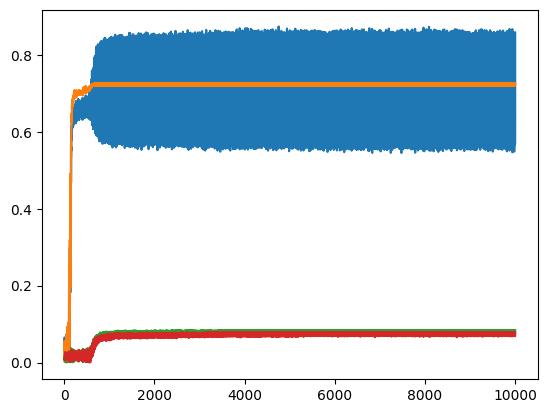

In [397]:
plt.plot(t,abs(r))
plt.plot(t,abs(r0))
plt.plot(t,abs(r1m))
plt.plot(t,abs(r1p))

plt.plot(tm,sigma)
plt.plot(t,abs(r2m))
plt.plot(t,abs(r2p))

# plt.plot(t,abs(r3m))
# plt.plot(t,abs(r3p))

In [22]:
STEP =  1000
EDT = get_TM(dtheta,STEP)

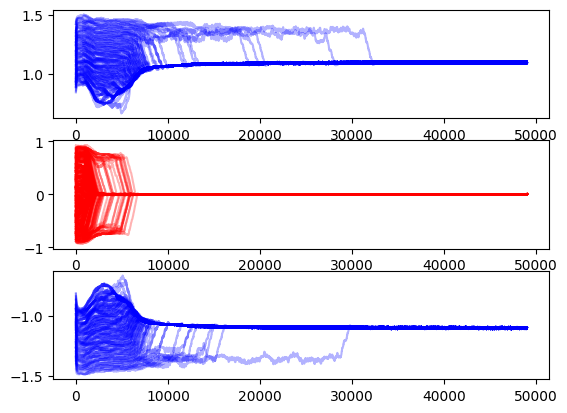

In [24]:
plt.subplot(311)
plt.plot(EDT[:,GP[1,'I']],color='blue',alpha=0.3);

plt.subplot(312)
plt.plot(EDT[:,G[0,'I']],color='red',alpha=0.3);
plt.subplot(313)
plt.plot(EDT[:,GM[1,'I']],color='blue',alpha=0.3);

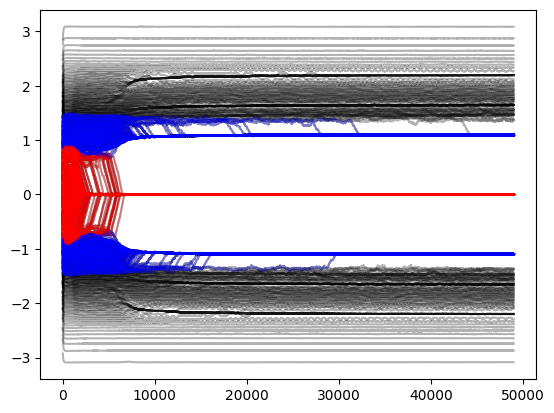

In [23]:
plt.plot(EDT,color='black',alpha=0.3);
plt.plot(EDT[:,G[0,'I']],color='red',alpha=0.3);
plt.plot(EDT[:,GP[1,'I']],color='blue',alpha=0.3);
plt.plot(EDT[:,GM[1,'I']],color='blue',alpha=0.3);
plt.show()

# 이론 그래프

In [194]:
import TO_sim.analytical.order_sec_parameter as OSP

In [214]:
m = 1
F_RMd2,F_RMu2,F_R0d2,F_R0u2 =  OSP.Make_R_function(m)

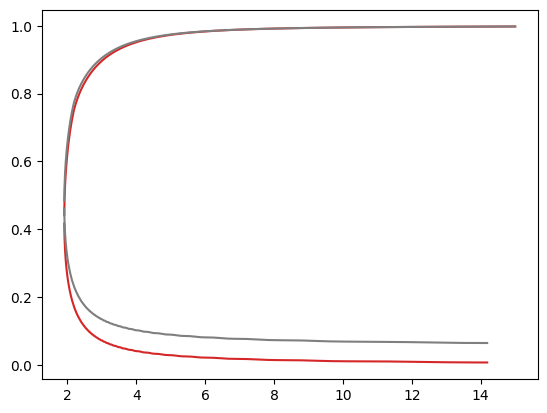

In [215]:
K_ = np.linspace(0,15,10000)

plt.plot(K_,F_RMd2(K_),color='tab:red')
plt.plot(K_,F_RMu2(K_),color='tab:red')

plt.plot(K_,F_R0d2(K_),color='tab:grey')
plt.plot(K_,F_R0u2(K_),color='tab:grey')


0.02

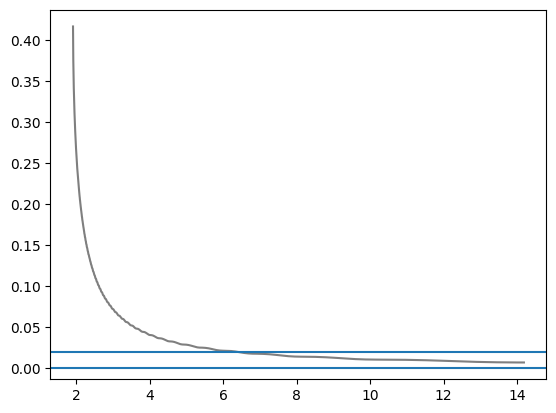

In [217]:
plt.plot(K_,F_RMd2(K_),color='tab:grey')
plt.plot(K_,F_RMd2(K_),color='tab:grey')
plt.axhline(0)
plt.axhline(0.02)
np.sqrt(2/N)

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.Kuramoto_model import Kuramoto_2nd_mf,Kuramoto_1st_mf
from scipy.stats import norm
from TO_sim.get_cluster import cluster_os_new2
from TO_sim.gen_Distribution import Normal, Quantile_Normal as Q_Normal, Lorentzian
import TO_sim.analytical.order_sec_parameter as OSP
import TO_sim.analytical.sec_order_parameter2 as OSP2
import TO_sim.Integrator_jit as IJ

RK4_jit = IJ.RK4
RK4_jit_short = IJ.RK4_short


class Q_Norm_simul():
    def __init__(self,N,K,m,dt = 0.1,t_end = 5000,seed = 10,start_p = False,g_n=None) -> None:
        '''input : N,K,m,dt. dt, t_end,seed'''
        self.seed = seed
        theta_random, omega, Kc = Q_Normal(N, 0, 1, seed=seed)
        if g_n!=None:
            dist = np.linspace(0,1,N+2)[1:-1]
            omega = g_n(dist)
        omega = np.sort(omega)-np.mean(omega)
        self.N = N; self.K = K; self.m = m;self.dt = dt
        self.t_end = t_end; self.dt = dt
        self.omega = omega
        self.t = np.arange(0, self.t_end+self.dt/2, self.dt)
        Theta = np.zeros(2*N)
        Theta[:N] = theta_random 
        if start_p:
            Theta[N:2*N] = omega
        self.Theta_init = Theta
        self.Theta_ori = Theta
    def solve(self):
        t = self.t
        if self.m == 0:
            func = Kuramoto_1st_mf
        else:
            func = Kuramoto_2nd_mf
            
        sol = RK4_jit(func,self.Theta_init,t, args=(self.omega, self.N, self.m, self.K))
        self.Last_sol = sol[-1]
        N = self.N
        theta,dtheta = sol[:,:N],sol[:,N:2*N]
        rabs = np.mean(np.exp(theta.T*1j),axis=0)
        rs = np.abs(rabs)
        psi = np.angle(rabs)
        if self.dt <0.1:
            t = t[::10]
            theta = theta[::10]
            dtheta = dtheta[::10]
            rs = rs[::10]
            psic = psic[::10]
        self.rs = rs
        self.psi = psi
        self.theta = theta
        self.dtheta = dtheta
        self.Theta_last = sol[-1]
        self.r_mean = np.mean(rs[-500:])
        solution = {}
        solution['rs'] = rs
        solution['psi'] = psi
        solution['r_mean'] = self.r_mean
        solution['r_std'] = np.std(rs[-2000:])
        solution['t'] = t
        solution['theta'] = theta
        solution['dtheta'] = dtheta
        solution['Theta_last'] = sol[-1]
        return solution
    
    def solve_short(self,result_time=2010):
        t = self.t
        if self.m == 0:
            func = Kuramoto_1st_mf
        else:
            func = Kuramoto_2nd_mf
            
        sol = RK4_jit_short(func,self.Theta_init,t, args=(self.omega, self.N, self.m, self.K),result_time=result_time)
        self.Last_sol = sol[-1]
        N = self.N
        theta,dtheta = sol[:,:N],sol[:,N:2*N]
        rabs = np.mean(np.exp(theta.T*1j),axis=0)
        rs = np.abs(rabs)
        psi = np.angle(rabs)
        if self.dt <0.1:
            t = t[::10]
            theta = theta[::10]
            dtheta = dtheta[::10]
            rs = rs[::10]
            psic = psic[::10]

        self.rs = rs
        self.psi = psi
        self.theta = theta
        self.dtheta = dtheta
        self.Theta_last = sol[-1]
        self.r_mean = np.mean(rs[-500:])
        solution = {}
        solution['rs'] = rs
        solution['psi'] = psi
        solution['r_mean'] = self.r_mean
        solution['r_std'] = np.std(rs[-2000:])
        solution['t'] = t
        solution['theta'] = theta
        solution['dtheta'] = dtheta
        solution['Theta_last'] = sol[-1]
        return solution
    

    def get_Group(self,L=2000,Nc=5):
        dt = self.dt
        theta = self.theta
        ARG = (theta[-1]-theta[-L])//np.pi
        avg_dtheta = ARG/(L-1)/dt
        self.avg_dtheta = avg_dtheta
        ARG =  np.where(ARG<0,ARG,ARG)
        u,c = np.unique(ARG,return_counts=True)

        I_c_o1 =np.where(c>Nc)
        u_o1 = u[I_c_o1]
        c_o1 = c[I_c_o1]
        u_c = np.argsort(c_o1)[::-1]
        UU = u_o1[u_c]

        arr = UU
        main_value = np.min(abs(arr))
        adjusted_arr = arr - main_value
        abs_arr = np.unique(np.abs(adjusted_arr))
        abs_arr
        group_threshold = 5
        G = {}
        GP = {}
        GM = {}
        G_num = 0
        GP_num = 1
        GM_num = 1
        for i in range(1,5):
            GP[i,'I'] = [];GP[i,'R'] = np.nan;GP[i,'L'] = np.nan;GP[i,'V'] = np.nan
            GM[i,'I'] = [];GM[i,'R'] = np.nan;GM[i,'L'] = np.nan;GM[i,'V'] = np.nan
        for i in range(5):
            abs_arr = np.unique(np.abs(adjusted_arr))
            for num in abs_arr:
                abs_adjust_arr = np.abs(adjusted_arr)
                in_group = np.int64(np.round((abs_adjust_arr-num)/group_threshold)) * group_threshold
                is_group = np.where(abs(in_group) < 1)
                not_group = np.where(in_group >= 1)
                if len(is_group) != 0:
                    print(num)
                    Ra_arr = adjusted_arr[is_group]
                    R = Ra_arr + main_value
                    if G_num == 0:
                        I, = np.where(np.isin(ARG,R))
                        G[G_num,'I'] = I
                        G[G_num,'R'] = R
                        G[G_num,'L'] = len(I)
                        G[G_num,'V'] = np.mean(R/(L-1)/dt)
                        G_num +=1
                    else:
                        gp_idx, = np.where(Ra_arr>0)
                        gm_idx, = np.where(Ra_arr<0)
                        Rp = R[gp_idx]
                        Rm = R[gm_idx]
                        Ip, = np.where(np.isin(ARG,Rp))
                        Im, = np.where(np.isin(ARG,Rm))
                        if (len(Rp) !=0) and (len(Rm) != 0):
                            GM[GM_num,'I'] = Im
                            GM[GM_num,'R'] = Rm
                            GM[GM_num,'V'] = np.mean(Rm/(L-1)/dt)
                            GM[GM_num,'L'] = len(Im)
                            GP[GP_num,'I'] = Ip
                            GP[GP_num,'R'] = Rp
                            GP[GP_num,'V'] = np.mean(Rp/(L-1)/dt)
                            GP[GP_num,'L'] = len(Ip)
                            GP_num += 1
                            GM_num += 1
                        elif (len(Rp) !=0):
                            GP[GP_num,'I'] = Ip
                            GP[GP_num,'R'] = Rp
                            GP[GP_num,'L'] = len(Ip)
                            GP[GP_num,'V'] = np.mean(Rp/(L-1)/dt)
                            GP_num += 1
                        else:
                            GM[GM_num,'I'] = Im
                            GM[GM_num,'R'] = Rm
                            GM[GM_num,'L'] = len(Im)
                            GM[GM_num,'V'] = np.mean(Rm/(L-1)/dt)
                            GM_num += 1
                adjusted_arr = adjusted_arr[not_group]
                break
            self.G = G
            self.GP = GP
            self.GM = GM
        return G,GM,GP

    def get_TMS(self,x,step):
        x_m = np.array([np.mean(x[i:i+step], axis=0) for i in range(len(self.t)-step)])
        x_std = np.array([np.std(x[i:i+step], axis=0) for i in range(len(self.t)-step)])
        return x_m,x_std
    def get_TM(self,x,step):
        x_c = np.cumsum(x,axis=0)
        if x.ndim == 2:
            x_m = (x_c[step:,:] - x_c[:-step,:])/step
        else:
            x_m = (x_c[step:] - x_c[:-step])/step
        return x_m
    def get_R(self,I,step):
        temp = 1/N*np.sum(np.exp(1j*self.theta[:, I]), axis=1)
        if len(I) == 0:
            temp = np.nan*temp
        rc = np.abs(temp)
        psic = np.angle(temp)
        rc_m,rc_std = self.get_TMS(rc,step)
        return rc,psic,rc_m,rc_std
    
    def get_R_last(self,I,sum_time):
        temp = 1/N*np.sum(np.exp(1j*self.theta[-sum_time:, I]), axis=1)
        if len(I) == 0:
            temp = np.nan*temp
        rc = np.abs(temp)
        psic_m = np.mean(np.angle(temp))
        rc_m,rc_std = np.mean(rc),np.std(rc)
        return rc_m,rc_std
            
    def get_r_clu(self,sum_time=500):
        N = self.N
        G,GM,GP = self.get_Group()
        r_info = {}
        rs = self.rs
        psi = self.psi
        rs_mean,rs_std = self.get_TMS(rs,sum_time)
        r_info['tm'] = self.get_TM(self.t,sum_time)
        r_info['T','R'],r_info['T','P'],r_info['T','RM'],r_info['T','RSTD'] = rs,psi,rs_mean,rs_std
        r_info['0','R'],r_info['0','P'],r_info['0','RM'],r_info['0','RSTD'] = self.get_R(G[0,'I'],sum_time)
        for i in range(1,5):
            r_info[f'{i}+','R'],r_info[f'{i}+','P'],r_info[f'{i}+','RM'],r_info[f'{i}+','RSTD'] = self.get_R(GP[i,'I'],sum_time)
            r_info[f'{i}-','R'],r_info[f'{i}-','P'],r_info[f'{i}-','RM'],r_info[f'{i}-','RSTD'] = self.get_R(GM[i,'I'],sum_time)
        return r_info
    
    
    def get_r_clu_last(self,sum_time=500):
        N = self.N
        r_info_last  = {}
        rs = self.rs[-sum_time:]
        psi = self.psi[-sum_time:]
        G,GM,GP = self.get_Group()

        rs_mean,rs_std = np.mean(rs),np.std(psi)
        r_info_last['T','RM'],r_info_last['T','RSTD'] = rs_mean,rs_std
        r_info_last['0','RM'],r_info_last['0','RSTD'] = self.get_R_last(G[0,'I'],sum_time)
        for i in range(1,5):
            r_info_last[f'{i}+','RM'],r_info_last[f'{i}+','RSTD'] = self.get_R_last(GP[i,'I'],sum_time)
            r_info_last[f'{i}-','RM'],r_info_last[f'{i}-','RSTD'] = self.get_R_last(GM[i,'I'],sum_time)
        return r_info_last
    def TLO(self,K_start=0,K_end = 15,dK = 0.1):
        N = self.N
        self.dK = dK
        Ks = np.arange(K_start,K_end+dK/2,dK)
        self.Theta_last = self.Theta_ori.copy()
        df_rset = pd.DataFrame(columns=['r_mean','r0','r+','r-','r+_total','r-_total',
                                        'sig_mean','sig0','sig+','sig-','sig+_total','sig-_total'],index=Ks)
        df_cluster = pd.DataFrame(columns=['S0','S+','S-','S+_total','S-_total',
                                           'v0','v+','v-','v+_total','v-_total',
                                           'max_O0','max_O+','max_O-','max_O+_total','max_O-_total',
                                           'min_O0','min_O+','min_O-','min_O+_total','min_O-_total',
                                           'mean_O0','mean_O+','mean_O-','mean_O+_total','mean_O-_total'],index=Ks)
        df_cluster_idx = pd.DataFrame(columns=['CLU0','CLU+','CLU-','CLU+_total','CLU-_total'],index=Ks)
        df_avglast = pd.DataFrame(columns=range(N),index=Ks)
        df_Thetalast = pd.DataFrame(columns=range(2*N),index=Ks)

        for K in Ks:
            self.K = K
            self.Theta_init = self.Theta_last
            sol = self.solve()
            clu_info = self.get_cluster()
            r_info = self.get_r_clu()
            # print(r_info)
            c_type = r_info['clu_name']
            r_cl = r_info['r_clu_mean_last']
            sig_c = r_info['r_clu_std']
            df_rset.loc[K]['r_mean'] = r_info['r_total_mean'][-1]
            df_rset.loc[K]['sig_mean'] = r_info['r_total_std'][-1]
            for c_t in c_type:
                if c_t == '0':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r0'] = r_cl[c_t]
                    df_rset.loc[K]['sig0'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S0'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v0'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[K]['max_O0'] = np.max(self.omega[clu])
                    df_cluster.loc[K]['min_O0'] = np.min(self.omega[clu])
                    df_cluster.loc[K]['mean_O0'] = np.mean(self.omega[clu])
                    df_cluster_idx.loc[K]['CLU0'] = np.sort(clu)
                if c_t == '+':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r+'] = r_cl[c_t]
                    df_rset.loc[K]['sig+'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S+'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v+'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[K]['max_O+'] = np.max(self.omega[clu])
                    df_cluster.loc[K]['min_O+'] = np.min(self.omega[clu])
                    df_cluster.loc[K]['mean_O+'] = np.mean(self.omega[clu])
                    df_cluster_idx.loc[K]['CLU+'] = np.sort(clu)
                if c_t == '-':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r-'] = r_cl[c_t]
                    df_rset.loc[K]['sig-'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S-'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v-'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[K]['max_O-'] = np.max(self.omega[clu])
                    df_cluster.loc[K]['min_O-'] = np.min(self.omega[clu])
                    df_cluster.loc[K]['mean_O-'] = np.mean(self.omega[clu])
                    df_cluster_idx.loc[K]['CLU-'] = np.sort(clu)
                if c_t == '+_total':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r+_total'] = r_cl[c_t]
                    df_rset.loc[K]['sig+_total'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S+_total'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v+_total'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[K]['max_O+_total'] = np.max(self.omega[clu])
                    df_cluster.loc[K]['min_O+_total'] = np.min(self.omega[clu])
                    df_cluster.loc[K]['mean_O+_total'] = np.mean(self.omega[clu])
                    df_cluster_idx.loc[K]['CLU+_total'] = np.sort(clu)
                if c_t == '-_total':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r-_total'] = r_cl[c_t]
                    df_rset.loc[K]['sig-_total'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S-_total'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v-_total'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[K]['max_O-_total'] = np.max(self.omega[clu])
                    df_cluster.loc[K]['min_O-_total'] = np.min(self.omega[clu])
                    df_cluster.loc[K]['mean_O-_total'] = np.mean(self.omega[clu])
                    df_cluster_idx.loc[K]['CLU-_total'] = np.sort(clu)
            df_avglast.loc[K] = clu_info['avg_dtheta_last']
            df_Thetalast.loc[K] = self.Theta_last
        TLO_info = {}
        TLO_info['Ks'] = Ks
        TLO_info['r_info'] = df_rset
        TLO_info['cluster_info'] = df_cluster 
        TLO_info['avg_dtheta'] = df_avglast
        TLO_info['Theta_last'] = df_Thetalast
        TLO_info['CLU_idx'] = df_cluster_idx
        return TLO_info
    
    def TLO_back(self,Theta,K_back = 15,dK = 0.1):
        N = self.N
        self.dK = dK

        Ks = np.arange(0,K_back+dK/2,dK)
        self.Theta_last = Theta
        df_rset = pd.DataFrame(columns=['r_mean','r0','r+','r-','r+_total','r-_total',
                                        'sig_mean','sig0','sig+','sig-','sig+_total','sig-_total'],index=Ks)
        df_cluster = pd.DataFrame(columns=['S0','S+','S-','S+_total','S-_total',
                                           'v0','v+','v-','v+_total','v-_total',
                                           'max_O0','max_O+','max_O-','max_O+_total','max_O-_total',
                                           'min_O0','min_O+','min_O-','min_O+_total','min_O-_total',
                                           'mean_O0','mean_O+','mean_O-','mean_O+_total','mean_O-_total'],index=Ks)
        df_cluster_idx = pd.DataFrame(columns=['CLU0','CLU+','CLU-','CLU+_total','CLU-_total'],index=Ks)
        df_avglast = pd.DataFrame(columns=range(N),index=Ks)
        df_Thetalast = pd.DataFrame(columns=range(2*N),index=Ks)

        for K in Ks[::-1]:
            self.K = K
            self.Theta_init = self.Theta_last
            sol = self.solve()
            clu_info = self.get_cluster()
            r_info = self.get_r_clu_last()
            c_type = r_info['clu_name']
            r_cl = r_info['r_clu_mean_last']
            sig_c = r_info['r_clu_std']
            df_rset.loc[K]['r_mean'] = r_info['r_total_mean'][-1]
            df_rset.loc[K]['sig_mean'] = r_info['r_total_std'][-1]
            for c_t in c_type:
                if c_t == '0':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r0'] = r_cl[c_t]
                    df_rset.loc[K]['sig0'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S0'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v0'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[K]['max_O0'] = np.max(self.omega[clu])
                    df_cluster.loc[K]['min_O0'] = np.min(self.omega[clu])
                    df_cluster.loc[K]['mean_O0'] = np.mean(self.omega[clu])
                    df_cluster_idx.loc[K]['CLU0'] = np.sort(clu)
                if c_t == '+':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r+'] = r_cl[c_t]
                    df_rset.loc[K]['sig+'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S+'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v+'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[K]['max_O+'] = np.max(self.omega[clu])
                    df_cluster.loc[K]['min_O+'] = np.min(self.omega[clu])
                    df_cluster.loc[K]['mean_O+'] = np.mean(self.omega[clu])
                    df_cluster_idx.loc[K]['CLU+'] = np.sort(clu)
                if c_t == '-':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r-'] = r_cl[c_t]
                    df_rset.loc[K]['sig-'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S-'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v-'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[K]['max_O-'] = np.max(self.omega[clu])
                    df_cluster.loc[K]['min_O-'] = np.min(self.omega[clu])
                    df_cluster.loc[K]['mean_O-'] = np.mean(self.omega[clu])
                    df_cluster_idx.loc[K]['CLU-'] = np.sort(clu)
                if c_t == '+_total':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r+_total'] = r_cl[c_t]
                    df_rset.loc[K]['sig+_total'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S+_total'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v+_total'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[K]['max_O+_total'] = np.max(self.omega[clu])
                    df_cluster.loc[K]['min_O+_total'] = np.min(self.omega[clu])
                    df_cluster.loc[K]['mean_O+_total'] = np.mean(self.omega[clu])
                    df_cluster_idx.loc[K]['CLU+_total'] = np.sort(clu)
                if c_t == '-_total':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r-_total'] = r_cl[c_t]
                    df_rset.loc[K]['sig-_total'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S-_total'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v-_total'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[K]['max_O-_total'] = np.max(self.omega[clu])
                    df_cluster.loc[K]['min_O-_total'] = np.min(self.omega[clu])
                    df_cluster.loc[K]['mean_O-_total'] = np.mean(self.omega[clu])
                    df_cluster_idx.loc[K]['CLU-_total'] = np.sort(clu)
            df_avglast.loc[K] = clu_info['avg_dtheta_last']
            df_Thetalast.loc[K] = self.Theta_last
        TLO_info = {}
        TLO_info['Ks'] = Ks
        TLO_info['r_info'] = df_rset
        TLO_info['cluster_info'] = df_cluster 
        TLO_info['avg_dtheta'] = df_avglast
        TLO_info['Theta_last'] = df_Thetalast
        TLO_info['CLU_idx'] = df_cluster_idx

        return TLO_info
    
    def KM_space(self,K_start=0,K_end = 15,dK = 0.1):
        N = self.N
        self.dK = dK
        Ks = np.arange(K_start,K_end+dK/2,dK)
        self.Theta_last = self.Theta_ori.copy()
        df_rset = pd.DataFrame(columns=['r_mean','r0','r+','r-','r+_total','r-_total',
                                        'sig_mean','sig0','sig+','sig-','sig+_total','sig-_total'],index=Ks)
        df_cluster = pd.DataFrame(columns=['S0','S+','S-','S+_total','S-_total',
                                           'v0','v+','v-','v+_total','v-_total',
                                           'max_O0','max_O+','max_O-','max_O+_total','max_O-_total',
                                           'min_O0','min_O+','min_O-','min_O+_total','min_O-_total',
                                           'mean_O0','mean_O+','mean_O-','mean_O+_total','mean_O-_total'],index=Ks)
        # df_cluster_idx = pd.DataFrame(columns=['CLU0','CLU+','CLU-','CLU+_total','CLU-_total'],index=Ks)
        # df_avglast = pd.DataFrame(columns=range(N),index=Ks)
        # df_Thetalast = pd.DataFrame(columns=range(2*N),index=Ks)

        for K in Ks:
            self.K = K
            self.Theta_init = self.Theta_ori.copy()
            sol = self.solve_short(result_time=self.t_end*10+1-2010)
            clu_info = self.get_cluster()
            r_info = self.get_r_clu_last()
            c_type = r_info['clu_name']
            r_cl = r_info['r_clu_mean_last']
            sig_c = r_info['r_clu_std']
            df_rset.loc[K]['r_mean'] = r_info['r_total_mean'][-1]
            df_rset.loc[K]['sig_mean'] = r_info['r_total_std'][-1]
            for c_t in c_type:
                if c_t == '0':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r0'] = r_cl[c_t]
                    df_rset.loc[K]['sig0'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S0'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v0'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[K]['max_O0'] = np.max(self.omega[clu])
                    df_cluster.loc[K]['min_O0'] = np.min(self.omega[clu])
                    df_cluster.loc[K]['mean_O0'] = np.mean(self.omega[clu])
                    # df_cluster_idx.loc[K]['CLU0'] = np.sort(clu)
                if c_t == '+':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r+'] = r_cl[c_t]
                    df_rset.loc[K]['sig+'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S+'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v+'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[K]['max_O+'] = np.max(self.omega[clu])
                    df_cluster.loc[K]['min_O+'] = np.min(self.omega[clu])
                    df_cluster.loc[K]['mean_O+'] = np.mean(self.omega[clu])
                    # df_cluster_idx.loc[K]['CLU+'] = np.sort(clu)
                if c_t == '-':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r-'] = r_cl[c_t]
                    df_rset.loc[K]['sig-'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S-'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v-'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[K]['max_O-'] = np.max(self.omega[clu])
                    df_cluster.loc[K]['min_O-'] = np.min(self.omega[clu])
                    df_cluster.loc[K]['mean_O-'] = np.mean(self.omega[clu])
                    # df_cluster_idx.loc[K]['CLU-'] = np.sort(clu)
                if c_t == '+_total':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r+_total'] = r_cl[c_t]
                    df_rset.loc[K]['sig+_total'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S+_total'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v+_total'] = clu_info['c_speed'][c_t]
                    if len(clu) != 0:
                        df_cluster.loc[K]['max_O+_total'] = np.max(self.omega[clu])
                        df_cluster.loc[K]['min_O+_total'] = np.min(self.omega[clu])
                        df_cluster.loc[K]['mean_O+_total'] = np.mean(self.omega[clu])
                    else:
                        df_cluster.loc[K]['max_O+_total'] = np.nan
                        df_cluster.loc[K]['min_O+_total'] = np.nan
                        df_cluster.loc[K]['mean_O+_total'] = np.nan
                    # df_cluster_idx.loc[K]['CLU+_total'] = np.sort(clu)
                if c_t == '-_total':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r-_total'] = r_cl[c_t]
                    df_rset.loc[K]['sig-_total'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S-_total'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v-_total'] = clu_info['c_speed'][c_t]
                    if len(clu) != 0:
                        df_cluster.loc[K]['max_O-_total'] = np.max(self.omega[clu])
                        df_cluster.loc[K]['min_O-_total'] = np.min(self.omega[clu])
                        df_cluster.loc[K]['mean_O-_total'] = np.mean(self.omega[clu])
                    else:
                        df_cluster.loc[K]['max_O-_total'] = np.nan
                        df_cluster.loc[K]['min_O-_total'] = np.nan
                        df_cluster.loc[K]['mean_O-_total'] = np.nan

                    # df_cluster_idx.loc[K]['CLU-_total'] = np.sort(clu)
            # df_avglast.loc[K] = clu_info['avg_dtheta_last']
        KM_info = {}
        KM_info['Ks'] = Ks
        KM_info['r_info'] = df_rset
        KM_info['cluster_info'] = df_cluster 
        # KM_info['avg_dtheta'] = df_avglast
        # KM_info['Theta_last'] = df_Thetalast
        # KM_info['CLU_idx'] = df_cluster_idx
        return KM_info
    
    def MK_space(self,m_start=0,m_end = 15,dm = 0.1):
        N = self.N
        self.dm = dm
        ms = np.arange(m_start,m_end+dm/2,dm)
        self.Theta_last = self.Theta_ori.copy()
        df_rset = pd.DataFrame(columns=['r_mean','r0','r+','r-','r+_total','r-_total',
                                        'sig_mean','sig0','sig+','sig-','sig+_total','sig-_total'],index=ms)
        df_cluster = pd.DataFrame(columns=['S0','S+','S-','S+_total','S-_total',
                                           'v0','v+','v-','v+_total','v-_total',
                                           'max_O0','max_O+','max_O-','max_O+_total','max_O-_total',
                                           'min_O0','min_O+','min_O-','min_O+_total','min_O-_total',
                                           'mean_O0','mean_O+','mean_O-','mean_O+_total','mean_O-_total'],index=ms)
        # df_cluster_idx = pd.DataFrame(columns=['CLU0','CLU+','CLU-','CLU+_total','CLU-_total'],index=ms)
        # df_avglast = pd.DataFrame(columns=range(N),index=ms)
        # df_Thetalast = pd.DataFrame(columns=range(2*N),index=ms)

        for m in ms:
            self.m = m
            self.Theta_init = self.Theta_ori.copy()
            sol = self.solve()
            clu_info = self.get_cluster()
            r_info = self.get_r_clu_last()
            c_type = r_info['clu_name']
            r_cl = r_info['r_clu_mean_last']
            sig_c = r_info['r_clu_std']
            df_rset.loc[m]['r_mean'] = r_info['r_total_mean'][-1]
            df_rset.loc[m]['sig_mean'] = r_info['r_total_std'][-1]
            for c_t in c_type:
                if c_t == '0':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[m]['r0'] = r_cl[c_t]
                    df_rset.loc[m]['sig0'] = sig_c[c_t][-1]
                    df_cluster.loc[m]['S0'] = clu_info['c_size'][c_t]
                    df_cluster.loc[m]['v0'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[m]['max_O0'] = np.max(self.omega[clu])
                    df_cluster.loc[m]['min_O0'] = np.min(self.omega[clu])
                    df_cluster.loc[m]['mean_O0'] = np.mean(self.omega[clu])
                    # df_cluster_idx.loc[m]['CLU0'] = np.sort(clu)
                if c_t == '+':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[m]['r+'] = r_cl[c_t]
                    df_rset.loc[m]['sig+'] = sig_c[c_t][-1]
                    df_cluster.loc[m]['S+'] = clu_info['c_size'][c_t]
                    df_cluster.loc[m]['v+'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[m]['max_O+'] = np.max(self.omega[clu])
                    df_cluster.loc[m]['min_O+'] = np.min(self.omega[clu])
                    df_cluster.loc[m]['mean_O+'] = np.mean(self.omega[clu])
                    # df_cluster_idx.loc[m]['CLU+'] = np.sort(clu)
                if c_t == '-':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[m]['r-'] = r_cl[c_t]
                    df_rset.loc[m]['sig-'] = sig_c[c_t][-1]
                    df_cluster.loc[m]['S-'] = clu_info['c_size'][c_t]
                    df_cluster.loc[m]['v-'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[m]['max_O-'] = np.max(self.omega[clu])
                    df_cluster.loc[m]['min_O-'] = np.min(self.omega[clu])
                    df_cluster.loc[m]['mean_O-'] = np.mean(self.omega[clu])
                    # df_cluster_idx.loc[m]['CLU-'] = np.sort(clu)
                if c_t == '+_total':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[m]['r+_total'] = r_cl[c_t]
                    df_rset.loc[m]['sig+_total'] = sig_c[c_t][-1]
                    df_cluster.loc[m]['S+_total'] = clu_info['c_size'][c_t]
                    df_cluster.loc[m]['v+_total'] = clu_info['c_speed'][c_t]
                    if len(clu) != 0:
                        df_cluster.loc[m]['max_O+_total'] = np.max(self.omega[clu])
                        df_cluster.loc[m]['min_O+_total'] = np.min(self.omega[clu])
                        df_cluster.loc[m]['mean_O+_total'] = np.mean(self.omega[clu])
                    else:
                        df_cluster.loc[m]['max_O+_total'] =np.nan
                        df_cluster.loc[m]['min_O+_total'] =np.nan
                        df_cluster.loc[m]['mean_O+_total'] =np.nan
                        # df_cluster_idx.loc[m]['CLU+_total'] = np.sort(clu)
                if c_t == '-_total':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[m]['r-_total'] = r_cl[c_t]
                    df_rset.loc[m]['sig-_total'] = sig_c[c_t][-1]
                    df_cluster.loc[m]['S-_total'] = clu_info['c_size'][c_t]
                    df_cluster.loc[m]['v-_total'] = clu_info['c_speed'][c_t]
                    if len(clu) !=0:
                        df_cluster.loc[m]['max_O-_total'] = np.max(self.omega[clu])
                        df_cluster.loc[m]['min_O-_total'] = np.min(self.omega[clu])
                        df_cluster.loc[m]['mean_O-_total'] = np.mean(self.omega[clu])
                    else:
                        df_cluster.loc[m]['max_O-_total'] = np.nan
                        df_cluster.loc[m]['min_O-_total'] = np.nan
                        df_cluster.loc[m]['mean_O-_total'] = np.nan
                        # df_cluster_idx.loc[m]['CLU-_total'] = np.sort(clu)
            # df_avglast.loc[m] = clu_info['avg_dtheta_last']
            # df_Thetalast.loc[m] = self.Theta_last
        KM_info = {}
        KM_info['ms'] = ms
        KM_info['r_info'] = df_rset
        KM_info['cluster_info'] = df_cluster 
        # KM_info['avg_dtheta'] = df_avglast
        # KM_info['Theta_last'] = df_Thetalast
        # KM_info['CLU_idx'] = df_cluster_idx
        return KM_info
    
    
    def get_STEP(self,TLO_info,s_length=2):
        S0 = TLO_info['cluster_info']['S0'].dropna()
        Ks = S0.index
        dK = Ks[1] - Ks[0]

        S0_ = np.r_[0,S0]
        diff_S0 = np.diff(S0_)

        A, = np.where(diff_S0>0)
        diff_A = np.diff(A)
        diff_3, = np.where(diff_A>s_length)
        A3 =A[diff_3]
        A3_end =A[diff_3+1]
        STEP_start = Ks[A3]
        STEP_end = Ks[A3_end]-dK
        return STEP_start,STEP_end
    
    def MAKE_STEP(self,TLO_info,s_length=2,P_dK = 0.3):
        STEP_start,STEP_end = self.get_STEP(TLO_info,s_length=s_length)
        Ks = TLO_info['Ks']
        dK = Ks[1] - Ks[0]
        Ks_ = TLO_info['Theta_last'].index
        df_STEP = pd.DataFrame(columns=['S_start','S_end','Ks_step','F_RMu','F_R0u','rs_d','rs_u'],index=STEP_start)
        _,F_RMu_,_,F_R0u_ =  OSP2.Make_R_function(self.m)
        K_t = np.linspace(0,15,30000)

        for s_start,s_end in zip(STEP_start,STEP_end):
            iloc = np.searchsorted(Ks_,s_start)
            # r_0 = TLO_info['r_info']['r0'].iloc[iloc]
            O_O = TLO_info['cluster_info']['max_O0'].iloc[iloc]
            O_2O = TLO_info['cluster_info']['max_O+'].iloc[iloc]

            # r_M = TLO_info['r_info']['r_mean'].iloc[iloc]
            # r_p = TLO_info['r_info']['r+'].iloc[iloc]
            # O_O = 4/np.pi * np.sqrt(F_RMu_(s_start)*s_start/self.m)- 0.3056*1/np.sqrt(s_start*F_RMu_(s_start)*self.m**3)
            _,F_RMu,_,F_R0u =  OSP2.Make_R0_function(self.m,O_O)
            _,_,rs_d,rs_u,_,_= OSP2.get_r_sec_np(s_start,self.m,F_RMu_,samples=30)

            r0 = F_R0u(s_start)
            rp = rs_u
            # shift_O = -(s_start**2*rp*r0)/(2*self.m*(1/self.m**2+(O_O)**2))  -(s_start**2*rp*rp)/(2*self.m*(1/self.m**2+(O_O)**2))

            # O_2O = O_O-shift_O + 4/np.pi * np.sqrt(rp*s_start/self.m) - 0.3056*1/np.sqrt(s_start*rp*self.m**3)
            Ks_S = np.arange(s_start-P_dK/4,s_end+P_dK+dK/2,dK)
            # rs_dt,rs_ut,rs_d,rs_u,md,mu= OSP2.get_r_sec_np(Ks_S,self.m,F_RMu,samples=30)
            # _,_,rs_d,rs_u= OSP2.get_r_sec0_np(Ks_S,r0,shift_O,self.m,O_O,O_2O,F_RMu,samples=30)
            
            F_S,F_OR = OSP2.get_shift(O_O)
            d,u,rs_d,rs_u= OSP2.get_r_sec0_np(Ks_S,self.m,O_O,O_2O,F_R0u_,F_S,F_OR,samples=40)
            # _,_,rs_d,rs_u= OSP2.get_r_sec0_np(Ks_S,r0,shift_O,self.m,O_O,O_2O,F_RMu,samples=30)
            df_STEP.loc[s_start]['S_start'] = s_start
            df_STEP.loc[s_start]['S_end'] = s_end
            df_STEP.loc[s_start]['Ks_step'] = Ks_S
            df_STEP.loc[s_start]['F_RMu'] = F_RMu
            df_STEP.loc[s_start]['F_R0u'] = F_R0u
            df_STEP.loc[s_start]['rs_d'] = rs_d
            df_STEP.loc[s_start]['rs_u'] = rs_u
        return df_STEP



In [115]:
N,K,m = 1000,6,7

In [116]:
Qsimul = Q_Norm_simul(N,K=K,m = m,t_end=2000,start_p=True,seed=6)
Qsimul.Theta_init[N:] = np.random.uniform(-1,1,N)
sol = Qsimul.solve()
omega = Qsimul.omega

In [117]:
r_info_last = Qsimul.get_r_clu_last()
r_info = Qsimul.get_r_clu()

0.0
74.0
111.0
148.0
0.0
74.0
111.0
148.0


In [127]:
clu_name = set()

for clu,_ in r_info_last.keys():
    clu_name.add(clu)

In [128]:
clu_name

{'0', '1+', '1-', '2+', '2-', '3+', '3-', '4+', '4-', 'T'}

In [125]:
pd.DataFrame(np.array(r_info_last))

ValueError: Must pass 2-d input. shape=()

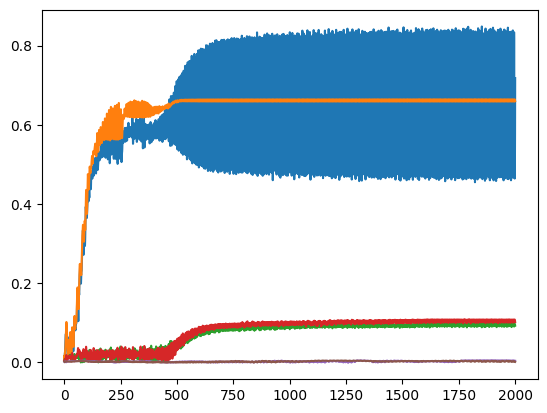

In [99]:

tm = Qsimul.t
plt.plot(tm,r_info['T','R'])
plt.plot(tm,r_info[0,'R'])
plt.plot(tm,r_info['1+','R'])
plt.plot(tm,r_info['1-','R'])
plt.plot(tm,r_info['2+','R'])
plt.plot(tm,r_info['2-','R'])

In [100]:
for i in range(0):
    print(i)

In [108]:
pd.DataFrame(r_info_last)

ValueError: If using all scalar values, you must pass an index

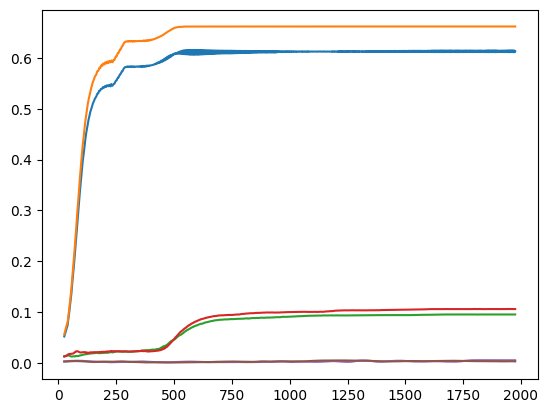

In [102]:
tm = r_info['tm']
# tm = Qsimul.t
plt.plot(tm,r_info['T','RM'])
plt.plot(tm,r_info[0,'RM'])
plt.plot(tm,r_info['1+','RM'])
plt.plot(tm,r_info['1-','RM'])

plt.plot(tm,r_info['2+','RM'])
plt.plot(tm,r_info['2-','RM'])

In [103]:
GP[3,'I']

array([1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932,
       1933, 1934])

In [104]:
AVD = Qsimul.avg_dtheta
G,GM,GP = Qsimul.get_Group(Nc=10)

0.0
72.0
97.0
109.0
145.0


In [105]:
GP[3,'I']


array([1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926,
       1927, 1928, 1929, 1930])

In [106]:
len(AVD)

2000

0.0
72.0
97.0
109.0
145.0


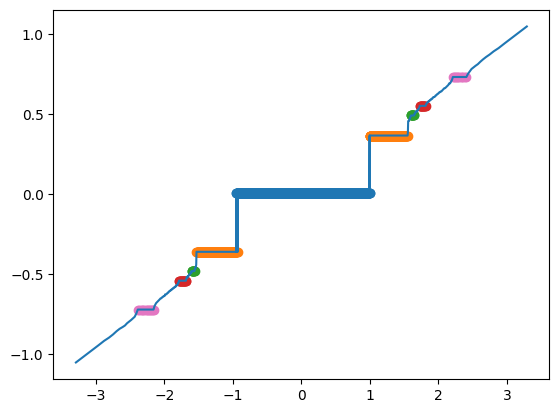

In [107]:
AVD = Qsimul.avg_dtheta
G,GM,GP = Qsimul.get_Group(Nc=5)
omega = Qsimul.omega
plt.plot(omega,AVD)
plt.scatter(omega[G[0,'I']],AVD[G[0,'I']])
plt.scatter(omega[GM[1,'I']],AVD[GM[1,'I']],color='tab:orange')
plt.scatter(omega[GP[1,'I']],AVD[GP[1,'I']],color='tab:orange')
plt.scatter(omega[GM[2,'I']],AVD[GM[2,'I']],color= 'tab:green')
plt.scatter(omega[GP[2,'I']],AVD[GP[2,'I']],color= 'tab:green')
plt.scatter(omega[GM[3,'I']],AVD[GM[3,'I']],color= 'tab:red')
plt.scatter(omega[GP[3,'I']],AVD[GP[3,'I']],color= 'tab:red')


plt.scatter(omega[GM[4,'I']],AVD[GM[4,'I']],color='tab:pink')
plt.scatter(omega[GP[4,'I']],AVD[GP[4,'I']],color='tab:pink')

In [94]:
print(G[0,'V'] - GM[1,'V'],GP[1,'V'] - G[0,'V'])
print(GM[1,'V'] - GM[2,'V'],GP[2,'V'] - GP[1,'V'])

0.3701850925462731 0.3651825912956478
0.12506253126563283 0.12506253126563283


In [69]:
G,GM,GP = Qsimul.get_Group(2000)
GM

0.0
60.0
90.0
120.0


{(1,
  'I'): array([ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
        181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
        194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
        207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 224, 225, 227, 230, 231, 233, 235, 238, 239]),
 (1, 'R'): array([-58.]),
 (1, 'L'): 142,
 (1, 'V'): -0.2901450725362681,
 (2,
  'I'): array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
        87, 88, 89]),
 (2,

In [600]:
temp = 1/N*np.sum(np.exp(1j*theta[:, []]), axis=1)
np.mean(np.nan)

nan